In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof, noof

In [2]:
train_df, val_df = shmoof.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv")# , sample_count=5000)

In [3]:
# Tang data

# full_df = pd.read_csv("/Users/matsen/data/tang-deepshm_size2_edges_22-May-2023.branch_length.csv", index_col=0).reset_index(drop=True)
# 
# # only keep rows where parent is different than child
# full_df = full_df[full_df["parent"] != full_df["child"]]
# 
# train_df = full_df.sample(frac=0.8)
# val_df = full_df.drop(train_df.index)


In [4]:
kmer_length = 5
max_length = 410

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 35830 training examples and 13186 validation examples


In [5]:
train_df["parent"].str.len().median()
#train_df["v_int_end"].hist(bins=100)
# get the index of the maximum True entry of train_dataset[0][1]
masks = train_dataset.masks
masks.shape

torch.Size([35830, 410])

In [6]:
def sequence_length_of_masks(masks):
    batch_size, seq_length = masks.shape

    range_tensor = torch.arange(seq_length).repeat(batch_size, 1)
    masked_range = torch.where(masks, range_tensor, torch.tensor(-1))

    return masked_range.max(dim=1)[0]

sequence_length_of_masks(masks).median()

tensor(364)

In [7]:
class TwoLengthSHMoofModel(nn.Module):
    def __init__(self, dataset, length_threshold):
        super(TwoLengthSHMoofModel, self).__init__()
        self.kmer_count = len(dataset.kmer_to_index)
        self.site_count = dataset.max_length
        self.length_threshold = length_threshold

        self.kmer_embedding = nn.Embedding(self.kmer_count, 1)
        self.log_site_rates_short = nn.Embedding(self.site_count, 1)
        self.log_site_rates_long = nn.Embedding(self.site_count, 1)

    def forward(self, encoded_parents, masks):
        log_kmer_rates = self.kmer_embedding(encoded_parents).squeeze()
        sequence_length = sequence_length_of_masks(masks)

        # Determine if the sequence is long or short
        is_long = sequence_length > self.length_threshold
        is_long = is_long.unsqueeze(-1)

        log_site_rates_long = self.log_site_rates_long.weight.T.expand_as(log_kmer_rates)
        log_site_rates_short = self.log_site_rates_short.weight.T.expand_as(log_kmer_rates)
        log_site_rates = torch.where(is_long, log_site_rates_long, log_site_rates_short)

        rates = torch.exp(log_kmer_rates + log_site_rates)
        return rates

In [8]:
model = TwoLengthSHMoofModel(train_dataset, length_threshold=sequence_length_of_masks(masks).median())
burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)

starting training...
Epoch [1/100]	 Loss: 0.062726002	 Val Loss: 0.066904906
Epoch [2/100]	 Loss: 0.058553403	 Val Loss: 0.066556224
Epoch [3/100]	 Loss: 0.058457698	 Val Loss: 0.066530277
Epoch [4/100]	 Loss: 0.058457806	 Val Loss: 0.066532248
Epoch [5/100]	 Loss: 0.058457272	 Val Loss: 0.066579811
Epoch [6/100]	 Loss: 0.058459643	 Val Loss: 0.066568658
Epoch [7/100]	 Loss: 0.058461108	 Val Loss: 0.066573284
Epoch [8/100]	 Loss: 0.058473073	 Val Loss: 0.066534116
Epoch 00008: reducing learning rate of group 0 to 2.0000e-02.
Epoch [9/100]	 Loss: 0.058330406	 Val Loss: 0.066407879
Epoch [10/100]	 Loss: 0.058268254	 Val Loss: 0.06638885
Epoch [11/100]	 Loss: 0.058265792	 Val Loss: 0.066392379
Epoch [12/100]	 Loss: 0.058266716	 Val Loss: 0.066397687
Epoch [13/100]	 Loss: 0.058265604	 Val Loss: 0.066391283
Epoch [14/100]	 Loss: 0.058265162	 Val Loss: 0.066398763
Epoch [15/100]	 Loss: 0.058265485	 Val Loss: 0.066395704
Epoch 00015: reducing learning rate of group 0 to 4.0000e-03.
Epoch [16/

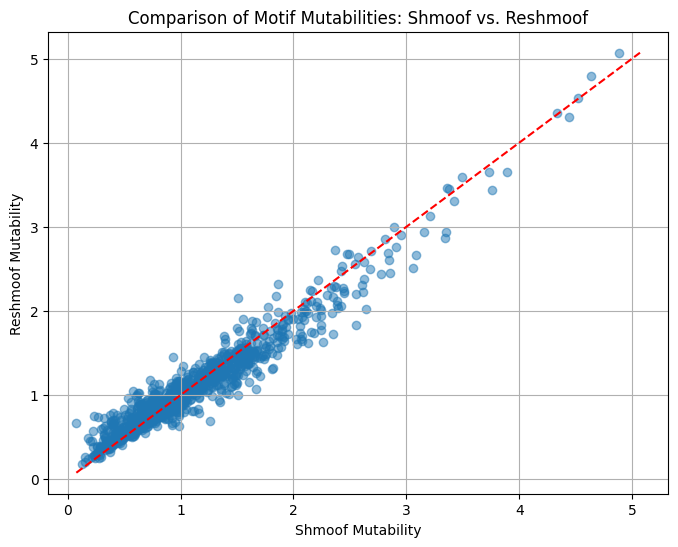

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
# rename Mutability column to Mutability_shmoof
#shmoof_motifs = shmoof_motifs.rename(columns={'Mutability': 'Mutability_shmoof'})
reshmoof_mutabilities = torch.exp(model.kmer_embedding.weight).squeeze().detach().numpy()
reshmoof_motifs = pd.DataFrame({'Mutability': reshmoof_mutabilities, 'Motif': train_dataset.kmer_to_index.keys()})

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

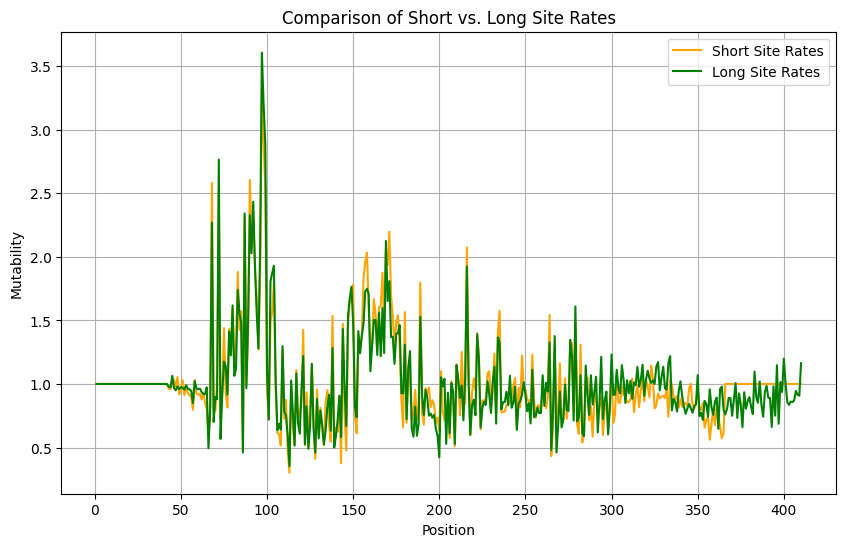

In [10]:
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Assuming `model` is your trained model instance
log_site_rates_short = model.log_site_rates_short.weight.data.squeeze().cpu().numpy()
log_site_rates_long = model.log_site_rates_long.weight.data.squeeze().cpu().numpy()

# Calculate the exponential of the log rates
site_rates_short = torch.exp(model.log_site_rates_short.weight).view(-1).detach().cpu().numpy()
site_rates_long = torch.exp(model.log_site_rates_long.weight).view(-1).detach().cpu().numpy()

# Ensure the site rates are 1-dimensional
assert site_rates_short.ndim == 1
assert site_rates_long.ndim == 1

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Position': range(1, len(site_rates_short) + 1),
    'Short_Site_Rates': site_rates_short,
    'Long_Site_Rates': site_rates_long
})

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(df['Position'], df['Short_Site_Rates'], label='Short Site Rates', color='orange')
plt.plot(df['Position'], df['Long_Site_Rates'], label='Long Site Rates', color='green')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Short vs. Long Site Rates')
plt.legend()
plt.grid(True)
plt.show()
